In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import seaborn as sns

In [2]:
x_scale = 5
y_scale = 3

full_court_img = Image.open('../../data/wnba/ml-bg-court.png').resize((x_scale * 100, y_scale * 100), Image.ANTIALIAS)
full_court_img.size

(500, 300)

In [3]:
df = pd.read_csv('../../data/wnba/wnba_shot_chart.csv')
df.head()

,game_id,description,location,made
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"['bottom:calc(32% - 5px);', 'left:calc(78.72% ...",False
1,401391651,Dana Evans misses driving floating jump shot,"['bottom:calc(42% - 5px);', 'left:calc(87.23% ...",False
2,401391651,Azura Stevens makes 23-foot three point jumper...,"['bottom:calc(6% - 5px);', 'left:calc(91.49% -...",True
3,401391651,Candace Parker makes 14-foot two point shot (A...,"['bottom:calc(26% - 5px);', 'left:calc(88.3% -...",True
4,401391651,Candace Parker makes free throw 1 of 2,"['bottom:calc(429496780% - 5px);', 'left:calc(...",True


In [4]:
def is_3pt(row):
    return len(re.findall(r'three\s+point', row)) > 0

df['is_3pt'] = df.description.map(is_3pt)

def who_shot(row):
    match = re.search(r'^([a-z]+[\s-]+)+(?=makes|misses)', row, flags=re.IGNORECASE)
    if match is not None:
        return match.group().strip()
        
    match = re.search(r'blocks\s+([a-z]+[\s-]+)+?(?=\'s)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return re.sub(r'^blocks\s+', '', match.group()).strip()

def who_blocked(row):
    match = re.search(r'^([a-z]+[\s-]+)+(?=blocks)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group().strip()

def distance(row):
    match = re.search(r'(\d+)[\s-]+foot', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group(1).strip()

def shot(row):
    match = re.search(r'(pullup|floating)\s+jump', row)
    if match is None:
        match = re.search(r'(layup)', row)

    if match is None:
        match = re.search(r'(free\s+throw)', row)

    if match is None:
        return 'set'

    return match.group(1).strip()

def assist(row):
    match = re.search(r'\(((?:[a-z]+[\s-])+)(?=assists)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group(1).strip()

df['shot_by'] = df.description.map(who_shot)
df['shot_distance'] = df.description.map(distance)
df['blocked_by'] = df.description.map(who_blocked)
df['shot_type'] = df.description.map(shot)
df['assist_by'] = df.description.map(assist)

In [5]:
def parse(loc):
  locations = list(map(float, re.findall(r'calc\(([\d.]+)%', ' '.join(loc))))
  if len(locations) != 2:
    return [-1, -1]

  return locations

def is_valid(loc):
  return not any(list(map(lambda a: a > 100 or a < 0, loc)))

df.location = df.location.map(eval).map(parse)
df['is_valid'] = df.location.map(is_valid)

df.head(n=10)

,game_id,description,location,made,is_3pt,shot_by,shot_distance,blocked_by,shot_type,assist_by,is_valid
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"[32.0, 78.72]",False,False,Courtney Vandersloot,18,,pullup,,True
1,401391651,Dana Evans misses driving floating jump shot,"[42.0, 87.23]",False,False,Dana Evans,,,floating,,True
2,401391651,Azura Stevens makes 23-foot three point jumper...,"[6.0, 91.49]",True,True,Azura Stevens,23,,set,Candace Parker,True
3,401391651,Candace Parker makes 14-foot two point shot (A...,"[26.0, 88.3]",True,False,Candace Parker,14,,set,Azura Stevens,True
4,401391651,Candace Parker makes free throw 1 of 2,"[429496780.0, 228455803.19]",True,False,Candace Parker,,,free throw,,False
5,401391651,Candace Parker makes free throw 2 of 2,"[429496780.0, 228455803.19]",True,False,Candace Parker,,,free throw,,False
6,401391651,Candace Parker makes 25-foot three point jumpe...,"[24.0, 73.4]",True,True,Candace Parker,25,,set,Courtney Vandersloot,True
7,401391651,Azura Stevens makes 2-foot layup (Candace Park...,"[48.0, 94.68]",True,False,Azura Stevens,2,,layup,Candace Parker,True
8,401391651,Azura Stevens misses two point shot,"[42.0, 95.74]",False,False,Azura Stevens,,,set,,True
9,401391651,Brittney Sykes blocks Kaela Davis 's 2-foot dr...,"[54.0, 93.62]",False,False,Kaela Davis,2,Brittney Sykes,layup,,True


In [6]:
## only use the valid shot locations moving forward
df = df[df.is_valid]

In [7]:
def side(loc):
  return 'right' if loc[1] >= 50  else 'left'

df['side_of_court'] = df.location.map(lambda loc: 'right' if loc[1] >= 50  else 'left')

def flip(row):

  location = row['location']

  if row['side_of_court'] == 'right':
    x = location[1]
    y = location[0]  

    return [round(100-y, 1), round(100-x, 1)]

  return location

df['single_location'] = df.apply(flip, axis=1)
df['side_of_the_half_court'] = df.single_location.map(lambda loc: 'right' if loc[0] < 50 else 'left') ## doesnt make sense yet...

df.head(n=5)

,game_id,description,location,made,is_3pt,shot_by,shot_distance,blocked_by,shot_type,assist_by,is_valid,side_of_court,single_location,side_of_the_half_court
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"[32.0, 78.72]",False,False,Courtney Vandersloot,18,,pullup,,True,right,"[68.0, 21.3]",left
1,401391651,Dana Evans misses driving floating jump shot,"[42.0, 87.23]",False,False,Dana Evans,,,floating,,True,right,"[58.0, 12.8]",left
2,401391651,Azura Stevens makes 23-foot three point jumper...,"[6.0, 91.49]",True,True,Azura Stevens,23,,set,Candace Parker,True,right,"[94.0, 8.5]",left
3,401391651,Candace Parker makes 14-foot two point shot (A...,"[26.0, 88.3]",True,False,Candace Parker,14,,set,Azura Stevens,True,right,"[74.0, 11.7]",left
6,401391651,Candace Parker makes 25-foot three point jumpe...,"[24.0, 73.4]",True,True,Candace Parker,25,,set,Courtney Vandersloot,True,right,"[76.0, 26.6]",left


In [8]:
player = 'Kelsey Plum' ## 'Sylvia Fowles'
df_player = df[df.shot_by == player]

df_player.head()

,game_id,description,location,made,is_3pt,shot_by,shot_distance,blocked_by,shot_type,assist_by,is_valid,side_of_court,single_location,side_of_the_half_court
1119,401391696,Kelsey Plum makes driving layup,"[48.0, 5.32]",True,False,Kelsey Plum,,,layup,,True,left,"[48.0, 5.32]",right
1130,401391696,Kelsey Plum makes driving layup,"[48.0, 4.26]",True,False,Kelsey Plum,,,layup,,True,left,"[48.0, 4.26]",right
1132,401391696,Kelsey Plum makes 25-foot three pointer (Jacki...,"[40.0, 29.79]",True,True,Kelsey Plum,25,,set,Jackie Young,True,left,"[40.0, 29.79]",right
1134,401391696,Kelsey Plum makes 24-foot step back jumpshot (...,"[20.0, 24.47]",True,False,Kelsey Plum,24,,set,Theresa Plaisance,True,left,"[20.0, 24.47]",right
1135,401391696,Kelsey Plum misses 24-foot step back jumpshot,"[70.0, 27.66]",False,False,Kelsey Plum,24,,set,,True,left,"[70.0, 27.66]",left


In [9]:
def get_makes_and_misses_full_court(df):
    def get_coordinates(df):
        x = df.location.map(lambda a: a[1])
        y = df.location.map(lambda a: a[0])

        return x, y

    df_sub = df[df.blocked_by.map(lambda bb: len(bb) == 0)]

    x_make, y_make = get_coordinates(df_sub[df_sub.made])
    x_missed, y_missed = get_coordinates(df_sub[~df_sub.made])

    return x_make, y_make, x_missed, y_missed

Kelsey Plum - shot chart


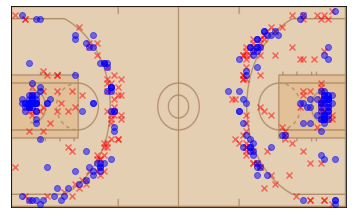

In [10]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])

x_make, y_make, x_missed, y_missed = get_makes_and_misses_full_court(df_player)

plt.scatter(x_missed * x_scale, y_missed * y_scale, marker='x', c='red', alpha=.5)
plt.scatter(x_make * x_scale, y_make * y_scale, marker='o', c='blue', alpha=.5)

plt.show()

In [11]:
def get_makes_and_misses_half_court(df):
    def get_coordinates(df):
        x = df.single_location.map(lambda a: a[1])
        y = df.single_location.map(lambda a: a[0])

        return x, y

    df_sub = df[df.blocked_by.map(lambda bb: len(bb) == 0)]

    x_make, y_make = get_coordinates(df_sub[df_sub.made])
    x_missed, y_missed = get_coordinates(df_sub[~df_sub.made])

    return x_make, y_make, x_missed, y_missed

Kelsey Plum - shot chart


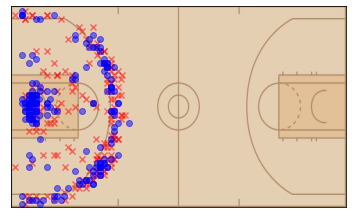

In [12]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

ax.imshow(full_court_img)

plt.xticks([])
plt.yticks([])

x_make, y_make, x_missed, y_missed = get_makes_and_misses_half_court(df_player)

plt.scatter(x_missed * x_scale, y_missed * y_scale, marker='x', c='red', alpha=.5)
plt.scatter(x_make * x_scale, y_make * y_scale, marker='o', c='blue', alpha=.5)

plt.show()

In [ ]:
## todo: data seems off... play by play might be better? note, this includes post / pre ...

In [13]:
df_player.groupby(['assist_by']).count()[['made']].sort_values(['made'], ascending=False)

,made
assist_by,
,339
Jackie Young,39
Chelsea Gray,30
Dearica Hamby,10
Riquna Williams,4
Sydney Colson,3
Theresa Plaisance,3
Aisha Sheppard,1
Iliana Rupert,1


In [ ]:
## 44-114, 2021 reg season totals

In [21]:
len(df_player[df_player.is_3pt]) - 114 - 31 - 5 ### would need to disappear? to reach reg season totals

## 12-31 post season ...
## 2-5 pre

## todo compare these totals vs game totals to see where issues are?

33

In [14]:
df_player[df_player.is_3pt].groupby(['made', 'side_of_the_half_court']).count()[['game_id']]

game_id
made  side_of_the_half_court         
False left                         67
      right                        39
True  left                         48
      right                        29

In [15]:
48 / (67 + 48)

0.41739130434782606

In [16]:
29 / (39 + 29)

0.4264705882352941